<h1 style="text-align:center;font-size:30px;" > Quora Question Pair Similarity Continued </h1>

### Notebook - 4

## Machine Learning Models

In [442]:
# First Things First
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm

# For models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

# for validation
from sklearn.model_selection import GridSearchCV

# Performanve metrics
from sklearn.metrics import log_loss, confusion_matrix, classification_report, make_scorer

In [443]:
# Loading data
data = pd.read_csv("final_features.csv")

In [444]:
data.shape

(404290, 632)

In [445]:
# Selecting 100k samples
data = data.sample(n=100000, axis=0, random_state=0, replace= False)
data.shape

(100000, 632)

In [18]:
# Splitting dependent and independent features
X = data.iloc[:,6:].values
y = data.iloc[:,5].values

In [20]:
# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=0)

## 1] Random Model (Finding worst-case log-loss)

In [265]:
def plot_confusion_matrix(y_true, y_pred):
    c = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(20,5))
    # Printing confusion matrix
    plt.subplot(1,3,1)
    sns.heatmap(c, annot=True, fmt="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion Matrix")
    
    # Printing Precision Matrix
    pr = c/c.sum(axis=0)
    plt.subplot(1,3,2)
    sns.heatmap(pr, annot=True, fmt=".3f")
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Precision Matrix")
    
    
    # Printing Recall Matrix
    re = (c.T/c.sum(axis=1)).T
    plt.subplot(1,3,3)
    sns.heatmap(re, annot=True, fmt=".3f")
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Recall Matrix")
    plt.show()
    
    

Log_loss for random model is : 0.8834083750339343


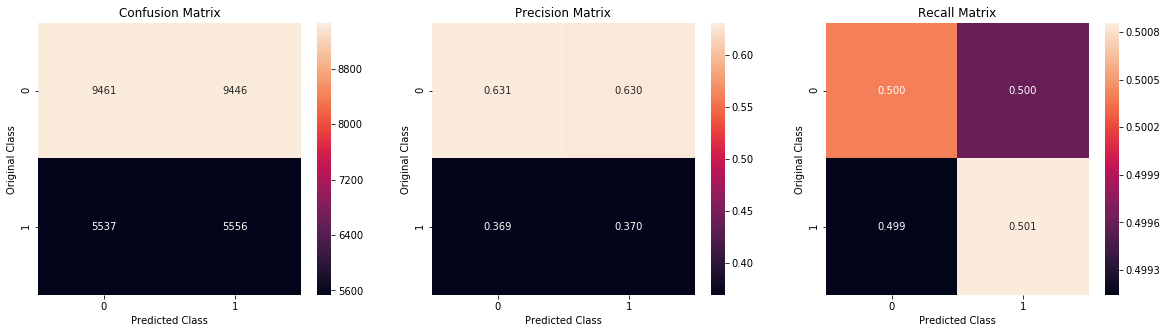

In [266]:
# Creating an array for stroring probablities of each class
y_predicted = np.zeros((len(y_test),2))

# loop for creating probalities
for i in range(len(y_test)):
    random_probs = np.random.rand(1,2)
    y_predicted[i] = (random_probs/np.sum(random_probs))[0]
print("Log_loss for random model is :", log_loss(y_test, y_predicted))

y_predicted = np.argmax(y_predicted, axis=1)
# Printing confusion Matrix
plot_confusion_matrix(y_test, y_predicted)

Observation -

The log_loss for random model is 0.88. It tells us that in worst case scenario or the worst value for this classification
will be 0.88.

Hence all the model which will be trained should give less value than this

## 2] Logistic Regression with hyperparameter tuning ¶

Log_loss for alpha:1e-05 is 0.43441997100737595
Log_loss for alpha:0.0001 is 0.4375239933057317
Log_loss for alpha:0.001 is 0.4356215161547032
Log_loss for alpha:0.01 is 0.4309460526159217
Log_loss for alpha:0.1 is 0.43711284710105136
Log_loss for alpha:1 is 0.4720539334908995
Log_loss for alpha:10 is 0.528900115747786
Log_loss for alpha:100 is 0.5806382779967693



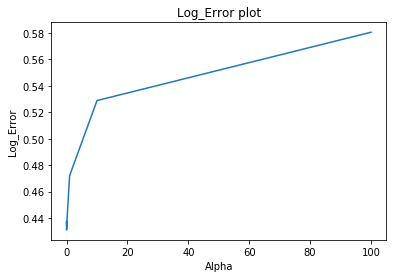

The best alpha is 0.01 having log_loss 0.4309460526159217
Log_loss on Test data :  0.4309460526159217
Log_loss on Train data:  0.42948559536901737


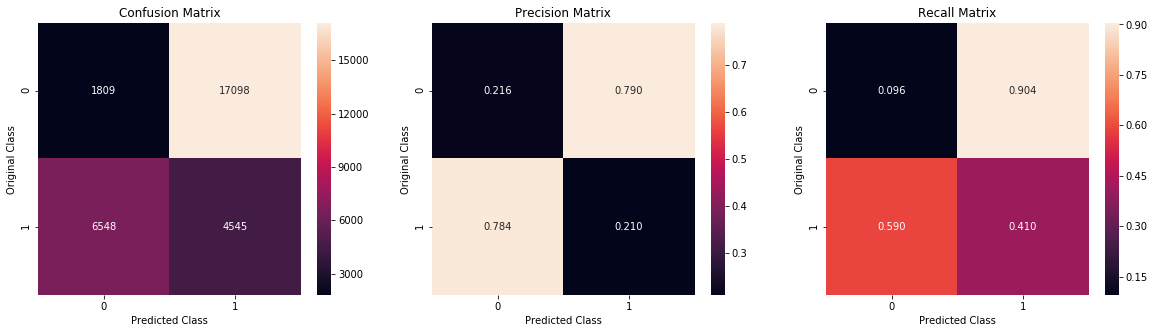

In [301]:
# hyperparameter values
alpha = [10 ** x for x in range(-5,3)]

log_error = []

for i in tqdm(alpha):
    
    
    # Intantiating SGDClassifier Model
    clf = SGDClassifier(loss="log", penalty="l2", alpha=i, random_state=0)
    clf.fit(X_train,y_train)

    # CalibrationModel for calibarting probablities
    calb_model = CalibratedClassifierCV(clf, method="sigmoid")
    calb_model.fit(X_train,y_train)

    #predecting on test data
    pred = calb_model.predict_proba(X_test)
    # Storing vlog_loss in log_error
    log_error.append(log_loss(y_test, pred, labels=clf.classes_))
    print("Log_loss for alpha:{} is {}".format(i, (log_loss(y_test, pred, labels=clf.classes_))))

    
# Getting best alpha
best_alpha = alpha[np.argmin(log_error)]

# Plotting alpha vs log_loss
fig,ax = plt.subplots()
ax.plot(alpha, log_error)
plt.xlabel("Alpha")
plt.ylabel("Log_Error")
plt.title("Log_Error plot")
plt.show()


print("The best alpha is {} having log_loss {}".format(best_alpha,np.min(log_error)))
# Instantiating SGDClassifier model using best alpha
sgd = SGDClassifier(alpha=best_alpha, penalty="l2", loss="log", random_state=0)
sgd.fit(X_train, y_train)
calb_clf = CalibratedClassifierCV(sgd, method="sigmoid")
calb_clf.fit(X_train, y_train)

# predciting on test data
y_pred = calb_clf.predict_proba(X_test)
# predicting on train data
y_pred_train = calb_clf.predict_proba(X_train)  

print("Log_loss on Test data : ",log_loss(y_test,y_pred))
print("Log_loss on Train data: ", log_loss(y_train,y_pred_train))
          
y_pred = np.argmin(y_pred, axis =1)
plot_confusion_matrix(y_test, y_pred)


<b>Observations on Logistic model</b> -

1] Main moto to keep log-loss less than 0.88 which is achieved.

2] Second thing which we can say is the log loss of train n test is same which means the model is not overfitting.

3] Third concerning point is the precision and recall bot are very low for both the classes.

## 2] Linear SVM with hyperparameter tuning

Log_loss for alpha 1e-05 is 0.4533665611428425
Log_loss for alpha 0.0001 is 0.4787246470812635
Log_loss for alpha 0.001 is 0.48633328793003616
Log_loss for alpha 0.01 is 0.4922057390008661
Log_loss for alpha 0.1 is 0.4791074866750781
Log_loss for alpha 1 is 0.5690683079574292
Log_loss for alpha 10 is 0.6462282625708963



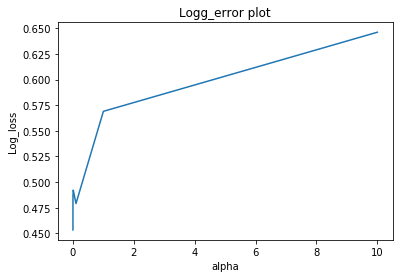

The best alpha is 1e-05 having log_loss 0.4533665611428425
Log loss on Test Data:  0.4533665611428425
Log loss on Train Data:  0.44922162923231956


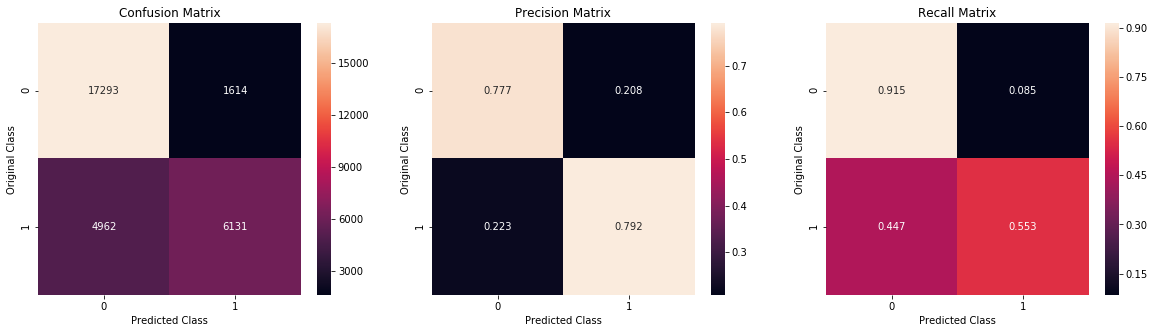

In [302]:
alpha = [10 ** x for x in range(-5,2)]

log_error = []

for i in tqdm(alpha):
    
    sgd = SGDClassifier(alpha=i,loss="hinge", penalty="l1", random_state=0)
    sgd.fit(X_train, y_train)
    clf = CalibratedClassifierCV(sgd, method="sigmoid")
    clf.fit(X_train, y_train)
    
    #predicting on test dat
    y_pred = clf.predict_proba(X_test)
    log_error.append(log_loss(y_test, y_pred))
    
    print("Log_loss for alpha {} is {}".format(i, log_loss(y_test, y_pred)))

# Getting best alpha
best_alpha = alpha[np.argmin(log_error)]

# plotting alpha vs log_erroe
plt.plot(alpha , log_error)
plt.xlabel("alpha")
plt.ylabel("Log_loss")
plt.title("Logg_error plot")
plt.show()

print("The best alpha is {} having log_loss {}".format(best_alpha, np.min(log_error)))

# Instantining the Classifier with best alpha
sgd = SGDClassifier(alpha= best_alpha, loss="hinge", penalty="l1", random_state=0)
sgd.fit(X_train, y_train)
clf = CalibratedClassifierCV(sgd, method="sigmoid")
clf.fit(X_train, y_train)

# predicting on test data
y_pred = clf.predict_proba(X_test)

# predicting on train data
y_pred_train = clf.predict_proba(X_train)

# Log loss on train and test data
print("Log loss on Test Data: ",log_loss(y_test,y_pred))
print("Log loss on Train Data: ",log_loss(y_train,y_pred_train))

# Printing confusion matrix
y_pred = y_pred.argmax(axis=1)
plot_confusion_matrix(y_test, y_pred)
      
      

<b>Observatios on SVM model</b> -

1] Main moto to keep log-loss less than 0.88 which is achieved.

2] Second thing which we can say is the log loss of train n test is same which means the model is not overfitting.<br>
   &nbsp; &nbsp; &nbsp;Also the metrics are same as logistics model.

3] The most crucial interpratation can be made by precision and recall matrix. They showed drastic improvement.

4} But the major concern still is the recall for postive class(1), its still low


## 2] XGBoost with hyperparameter tuning

In [346]:
#read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Hyper Tuning xgboost parameters

param_grid = {
    "max_depth":[2,3,4,5,7],
    "learning_rate":[0.01,0.1,1,2,3,4]
}

bst = xgb.train(dtrain,objective="binary:logistic")
clf = GridSearchCV(bst, param_grid=param_grid, return_train_score=True, error_score=make_scorer(log_loss))
clf.fit(X_train,y_train)


GridSearchCV(cv='warn', error_score=make_scorer(log_loss),
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 7], 'learning_rate': [0.01, 0.1, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [359]:
# Storing values
values = [clf.cv_results_.get("param_learning_rate"),clf.cv_results_.get("param_max_depth"),clf.cv_results_.get("mean_test_score"),clf.cv_results_.get("mean_train_score")]

In [360]:
# converting the results into dataframe
results = pd.DataFrame(values, index = ["param_learning_rate","param_max_depth","mean_test_score","mean_train_score"]).transpose()

In [361]:
results

,param_learning_rate,param_max_depth,mean_test_score,mean_train_score
0,0.01,2.0,0.755286,0.755636
1,0.01,3.0,0.796114,0.796557
2,0.01,4.0,0.806300,0.808564
3,0.01,5.0,0.811943,0.815000
4,0.01,7.0,0.814743,0.827629
5,0.10,2.0,0.810200,0.813657
6,0.10,3.0,0.819629,0.825900
7,0.10,4.0,0.824300,0.837000
8,0.10,5.0,0.827843,0.852979
9,0.10,7.0,0.830229,0.904257


In [440]:
best_param = results.nlargest(1,"mean_test_score")
best_param

,param_learning_rate,param_max_depth,mean_test_score,mean_train_score
9,0.1,7.0,0.830229,0.904257


Log Loss for Test data :  0.3338175299396253
Log Loss for Train data :  0.2697173737019758


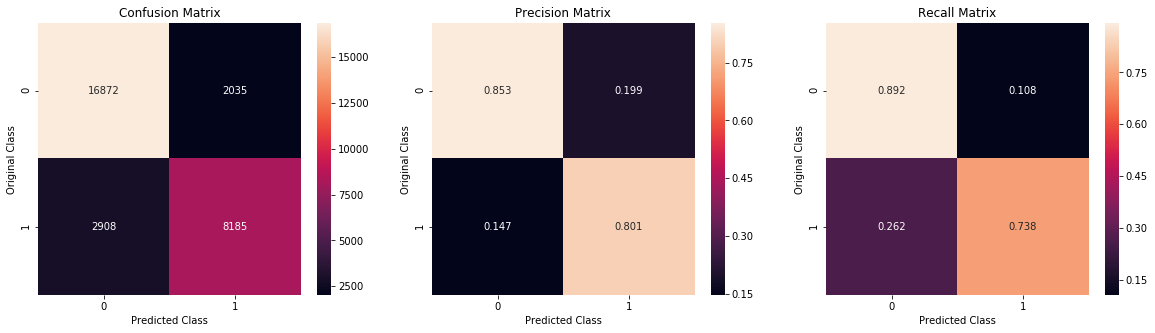

In [438]:
# TRaining XGMOdel with best param

# Instantiating XGBOOST model
bst = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective="binary:logistic")

bst.fit(X_train, y_train)

# predicting on test data
y_pred = bst.predict_proba(X_test)
# predicting on train data
y_pred_train = bst.predict_proba(X_train)

# LogLoss
print("Log Loss for Test data : ",log_loss(y_test,y_pred))
print("Log Loss for Train data : ",log_loss(y_train,y_pred_train))

# Confusion matrix
y_pred = y_pred.argmax(axis=1)
plot_confusion_matrix(y_test,y_pred)

<b>Observatios on XGBoost model</b> -

1] XGBoost gave us the best logloss.

2] Second thing which we can say is the log loss of train n test is almost same not mush of the difference  which means the model is not overfitting.<br>


3] The most crucial interpratation can be made by precision and recall matrix. They showed drastic improvement and are the best one uptill now or from other models.


4] Aa the log-loss is way to far from thw worst log loss hence we can say the model is also not overfitting.


5] Hence we will choose XGBoost as are go to model fo Question Similarity use case.

<h2 style="color:red;"><b> XGBoost is go to model for Quora Question Pair Similarity </b></h2>

In [ ]:
# # TRaining XGMOdel with best param

# #read in data
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# params = {"max_depth":4 , "eta": 4, "objective":"binary:logistic",
#       "eval_metric":"logloss"}

# num_round = 20

# #instantiating and traning model
# bst = xgb.train(params,dtrain,num_boost_round= 50,evals=[(dtest, "Validation")],early_stopping_rounds=10, verbose_eval=10)

# y_pred = bst.predict(dtest)